<h3 style="text-align: center;"><b>
Fully connected and convolutional neural networks</b></h3>









In [ ]:
import numpy as np
import random

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
seed = 42

# Set random seeds for PyTorch
torch.manual_seed(seed)

# Set random seed for Python's random module
random.seed(seed)

# Set random seed for NumPy
np.random.seed(seed)

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

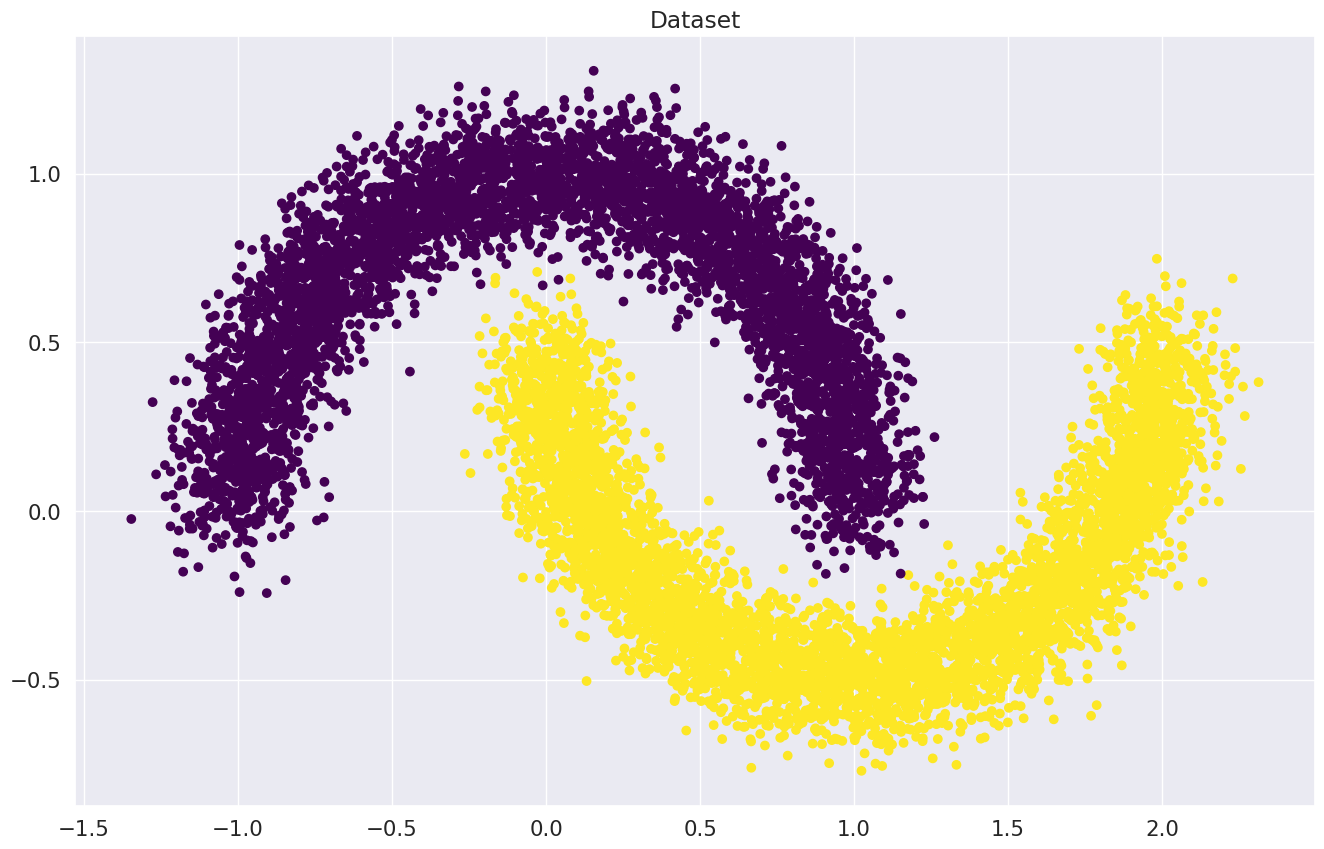

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.LongTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))


    def forward(self, x):
        x =  torch.mm(x, self.weights.t())
        if self.bias:
            x +=  self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:

total_params = sum([p.numel() for p in linear_regression.parameters() if p.requires_grad])

print(f"Total number of learning params: {total_params}")

Total number of learning params: 3


**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #Use linear_regression to get outputs
        #Compute loss
        outp = linear_regression(X_batch)

        # Ensure the shape of outp matches the shape of y_batch
        loss = loss_function(outp.view(-1), y_batch.float())

        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        #Compute probabilities
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 582 (min so far)

### Визуализируем результаты

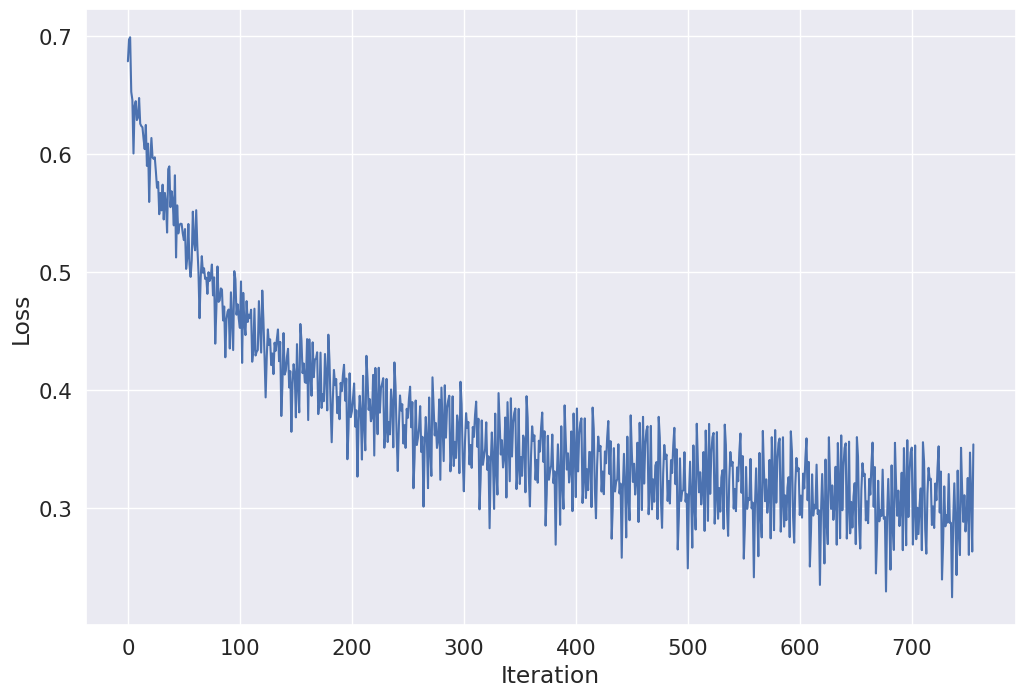

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

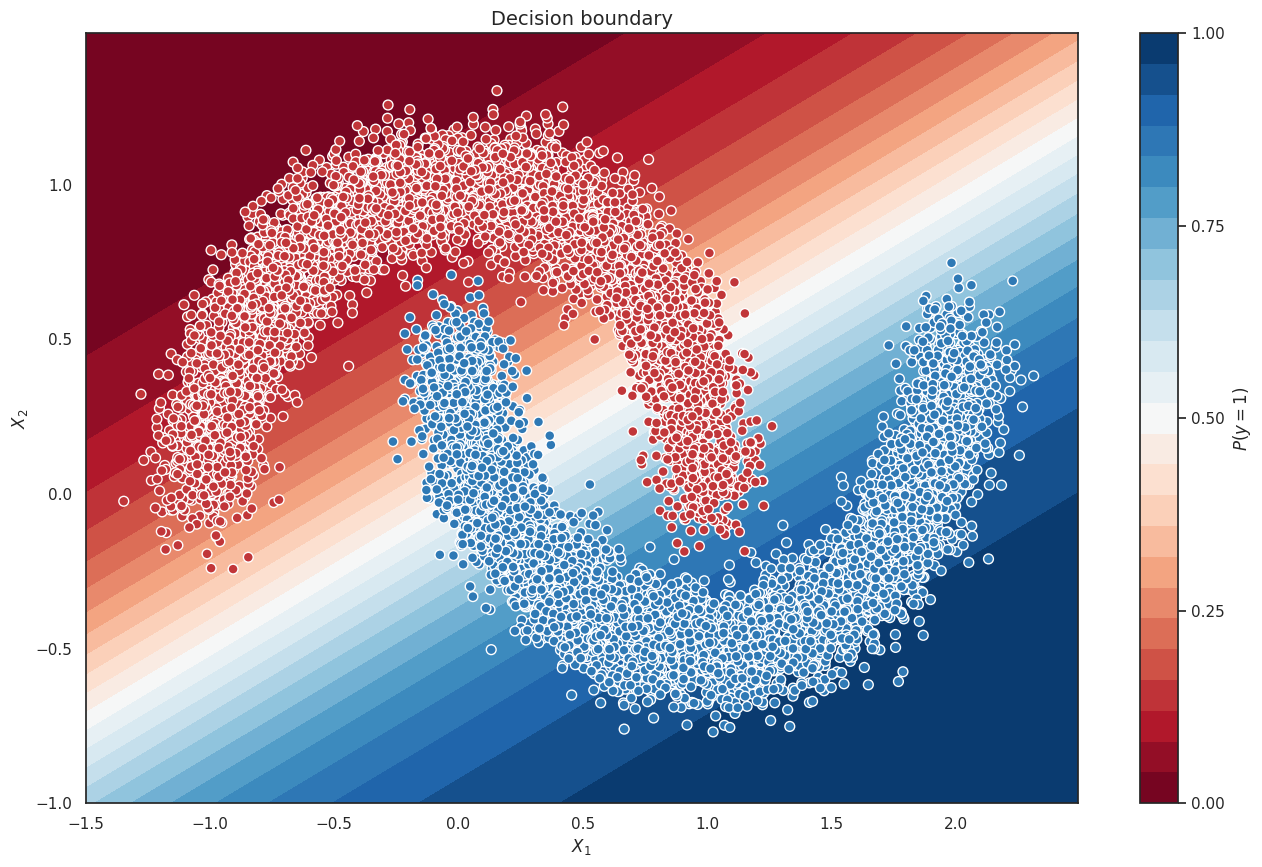

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        #Compute predictions
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

# Compute total accuracy
predictions  =  predict(val_dataloader,linear_regression)

# Access ground truth labels from val_dataloader
true_labels = []
for _, y_batch in val_dataloader:
    true_labels.extend(y_batch.numpy())

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predictions)

# Print the accuracy
print("Total Accuracy:", accuracy)

Total Accuracy: 0.862


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8684


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

import torch
import torchvision
from torchsummary import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=2)
valid_dataloader =  DataLoader(val_dataset, batch_size=128,shuffle=False, num_workers=2)

loaders = {"train": train_dataloader, "valid": valid_dataloader}


100%|██████████| 9912422/9912422 [00:00<00:00, 77859324.22it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29487754.10it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26171873.49it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9306560.22it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

# Check usage of Identical in a model
model = nn.Sequential(Identical())

for layer in model:
    print(layer)

Identical()


### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
# Access the data from the train_dataset
data = train_dataset.data

# Extract image width and height
image_width = data.size(2)
image_height = data.size(1)
in_features = image_width*image_height


In [ ]:
def create_model(activation):

  # Create a fully connected neural network using the Sequential class
  model = nn.Sequential(
  # Flatten the matrix into a vector
  nn.Flatten(),
  nn.Linear(in_features, 128),
  activation(),
  nn.Linear(128, 128),
  activation(),
  nn.Linear(128, 10))

  if device == "cuda":
    model = model.to(device)

  return model


In [ ]:
# Define the loss function for training (cross-entropy)
loss_function = nn.CrossEntropyLoss()

In [ ]:
#Select a loss function
criterion = loss_function


In [ ]:
# Create model
activation = nn.ELU
model = create_model(activation)


### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
def train_evaluate(model):

  optimizer = torch.optim.Adam(model.parameters())

  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                  #Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                  model.train()
                  optimizer.zero_grad()  # Zero the gradients
                  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to device
                  outp = model(x_batch)
              else:
                  # Set model to ``eval`` mode and calculate outputs
                  model.eval()
                  # Ensure no gradient calculation during validation
                  with torch.no_grad():
                      x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to device
                      outp = model(x_batch)

              preds = outp.argmax(-1)

              correct = (preds == y_batch).sum().item()

              all = y_batch.size(0)

              epoch_correct += correct
              epoch_all += all

              if k == "train":
                  loss = criterion(outp, y_batch.to(device))
                  # Calculate gradients and make a step of your optimizer
                  # Calculate gradients
                  loss.backward()
                  # Update model weights
                  optimizer.step()

          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)

  return accuracy

In [ ]:
accuracy = train_evaluate(model)


Epoch: 1
Loader: train. Accuracy: 0.8894333333333333
Loader: valid. Accuracy: 0.9384
Epoch: 2
Loader: train. Accuracy: 0.9483333333333334
Loader: valid. Accuracy: 0.958
Epoch: 3
Loader: train. Accuracy: 0.9625333333333334
Loader: valid. Accuracy: 0.9666
Epoch: 4
Loader: train. Accuracy: 0.9711333333333333
Loader: valid. Accuracy: 0.9669
Epoch: 5
Loader: train. Accuracy: 0.9749666666666666
Loader: valid. Accuracy: 0.9667
Epoch: 6
Loader: train. Accuracy: 0.97855
Loader: valid. Accuracy: 0.9732
Epoch: 7
Loader: train. Accuracy: 0.9824333333333334
Loader: valid. Accuracy: 0.971
Epoch: 8
Loader: train. Accuracy: 0.98355
Loader: valid. Accuracy: 0.9742
Epoch: 9
Loader: train. Accuracy: 0.985
Loader: valid. Accuracy: 0.9743
Epoch: 10
Loader: train. Accuracy: 0.9871166666666666
Loader: valid. Accuracy: 0.9777


In [ ]:
elu_accuracy = accuracy["valid"]


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
def test_activation_function(activation):

    # Check if CUDA (GPU support) is available
    if torch.cuda.is_available():
      # Clear GPU memory
      torch.cuda.empty_cache()

    # Create a model with the specified activation function
    model = create_model(activation)

    # Set the model to evaluation mode
    accuracy = train_evaluate(model)

    return accuracy["valid"]


In [ ]:
# Test the accuracy for different activation functions
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)


Epoch: 1
Loader: train. Accuracy: 0.8712333333333333
Loader: valid. Accuracy: 0.9054
Epoch: 2
Loader: train. Accuracy: 0.9050833333333334
Loader: valid. Accuracy: 0.9094
Epoch: 3
Loader: train. Accuracy: 0.9069833333333334
Loader: valid. Accuracy: 0.9051
Epoch: 4
Loader: train. Accuracy: 0.9093166666666667
Loader: valid. Accuracy: 0.9124
Epoch: 5
Loader: train. Accuracy: 0.9113333333333333
Loader: valid. Accuracy: 0.9144
Epoch: 6
Loader: train. Accuracy: 0.91215
Loader: valid. Accuracy: 0.9169
Epoch: 7
Loader: train. Accuracy: 0.9149833333333334
Loader: valid. Accuracy: 0.907
Epoch: 8
Loader: train. Accuracy: 0.9138166666666667
Loader: valid. Accuracy: 0.9185
Epoch: 9
Loader: train. Accuracy: 0.9143166666666667
Loader: valid. Accuracy: 0.9167
Epoch: 10
Loader: train. Accuracy: 0.9163
Loader: valid. Accuracy: 0.9172
Epoch: 1
Loader: train. Accuracy: 0.8673166666666666
Loader: valid. Accuracy: 0.9192
Epoch: 2
Loader: train. Accuracy: 0.9340166666666667
Loader: valid. Accuracy: 0.9451
Epo

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

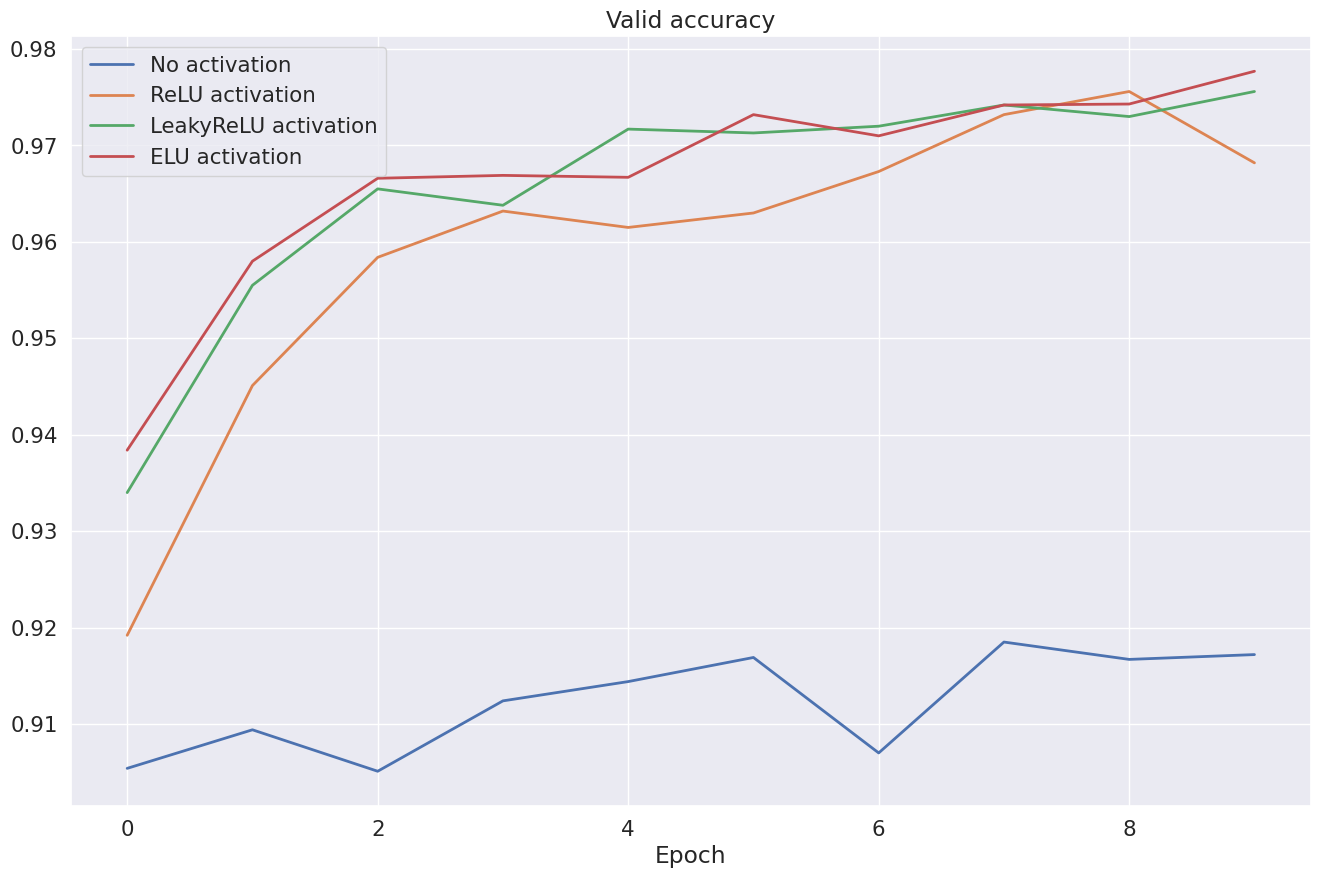

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(len(plain_accuracy)), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(len(relu_accuracy)), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(len(leaky_relu_accuracy)), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(len(elu_accuracy)), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

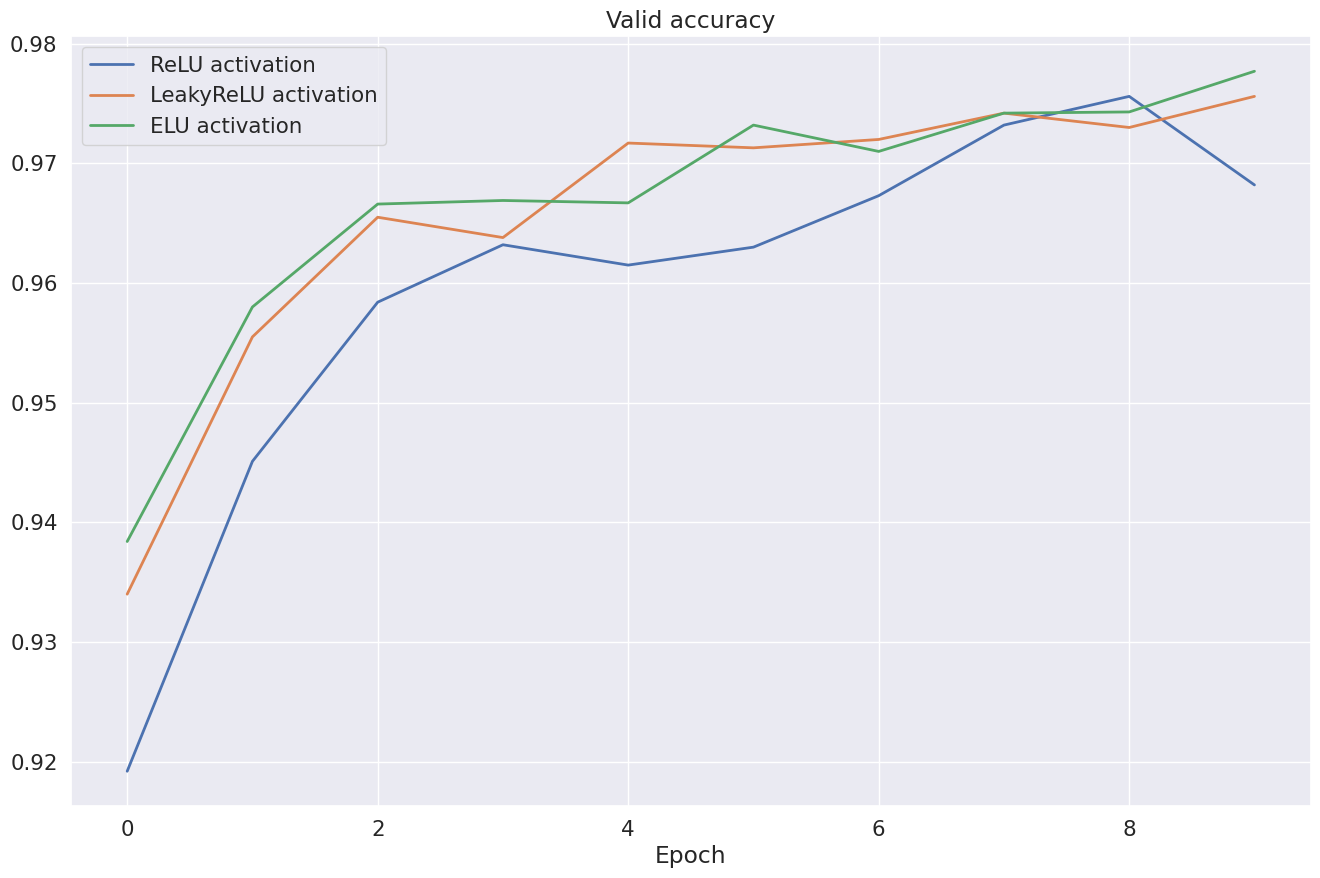

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(len(relu_accuracy)), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(len(leaky_relu_accuracy)), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(len(elu_accuracy)), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-06 03:41:05--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   234KB/s    in 0.2s    

2023-11-06 03:41:05 (234 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



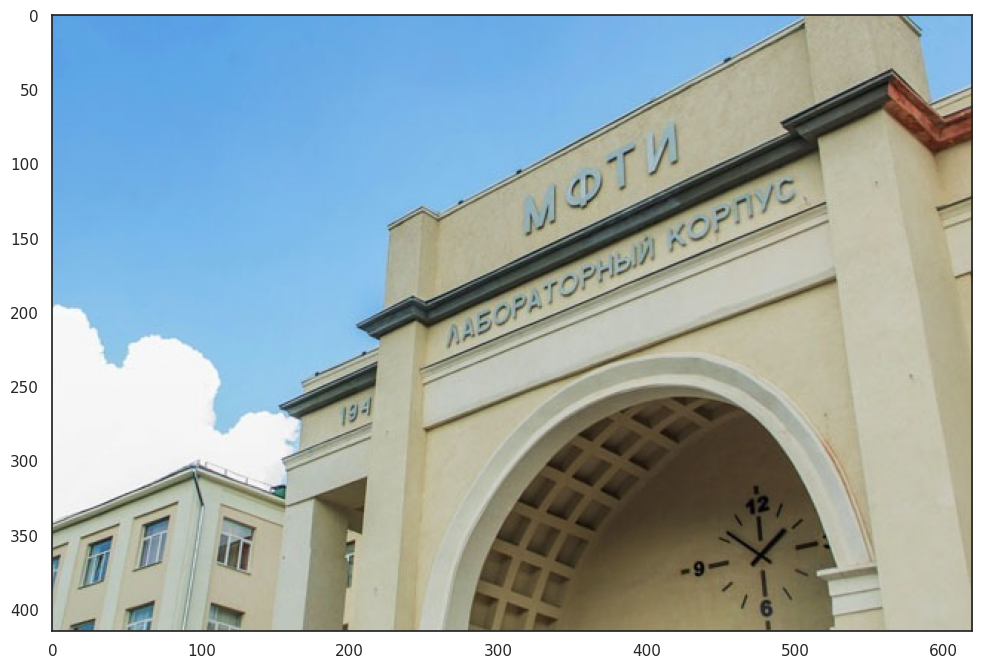

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
masks_names = ["A", "Б", "В", "Г", "Д", "Е"]

# List of masks
masks = [
[[0, 0, 0],
[0, 1, 0],
[0, 0, 0]],

[[0, 1, 0],
[0, -2, 0],
[0, 1, 0]],

[[0, 0, 0],
[1, -2, 1],
[0, 0, 0]],

[[0, 1, 0],
[1, -4, 1],
[0, 1, 0]],

[[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]],

[[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]]]

# Initialize an empty list to store the kernels
results = []

for mask in masks:
    # Reshape the current mask to match the format (out_channels, in_channels, height, width)
    kernel = torch.tensor(mask).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)

    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]
    results.append(result)

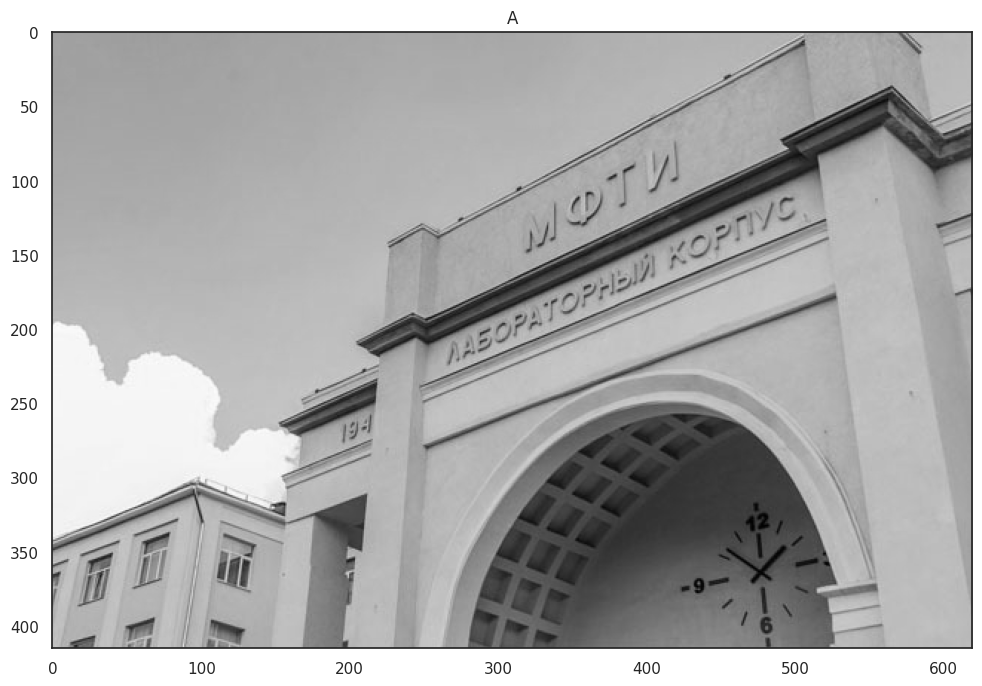

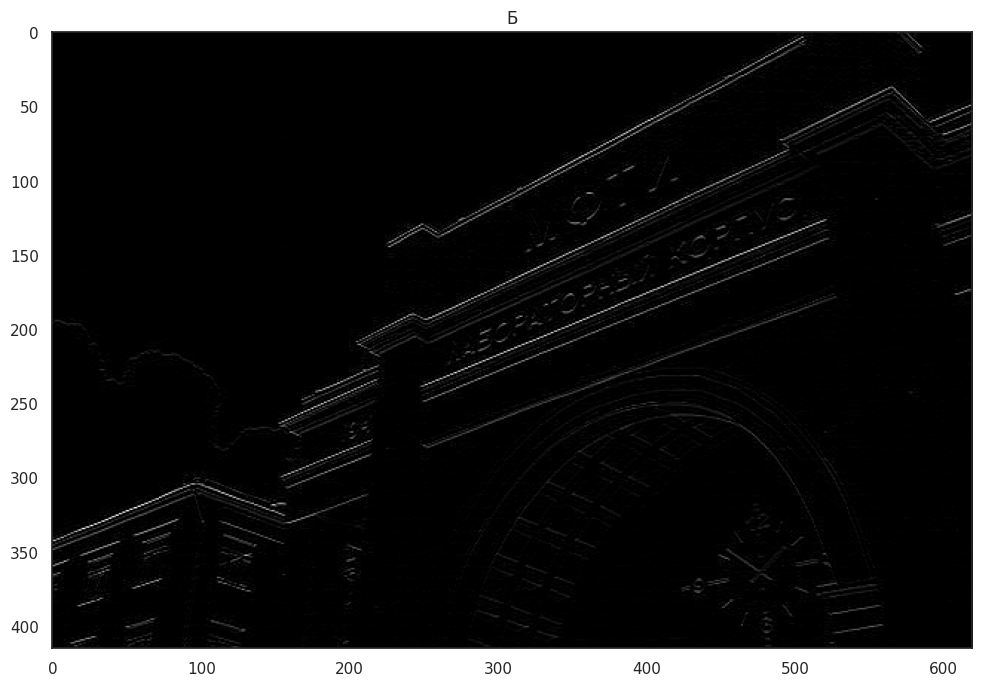

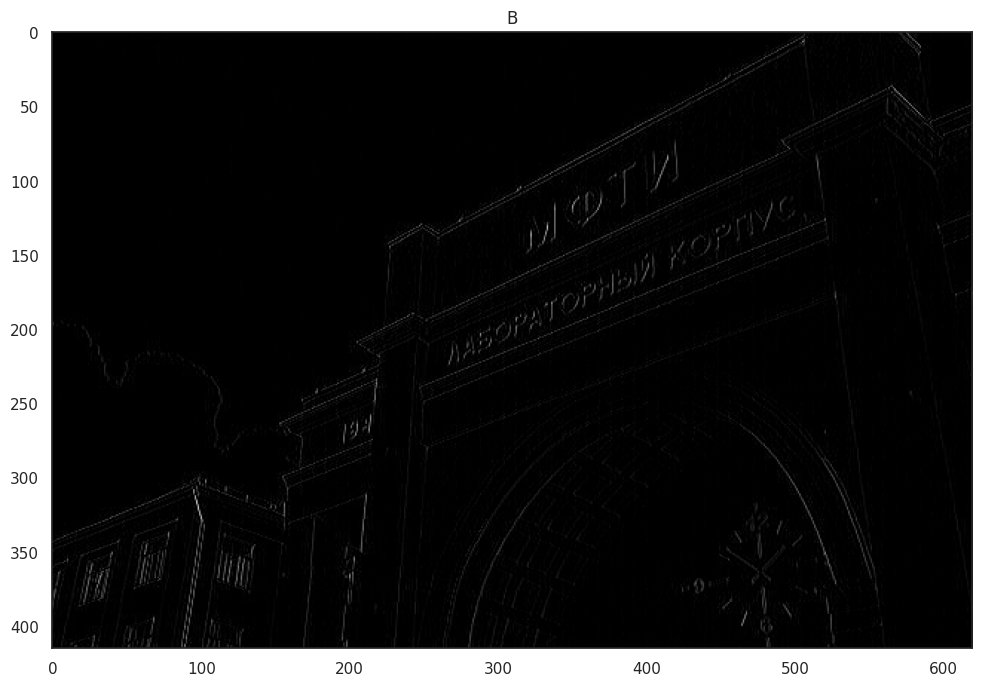

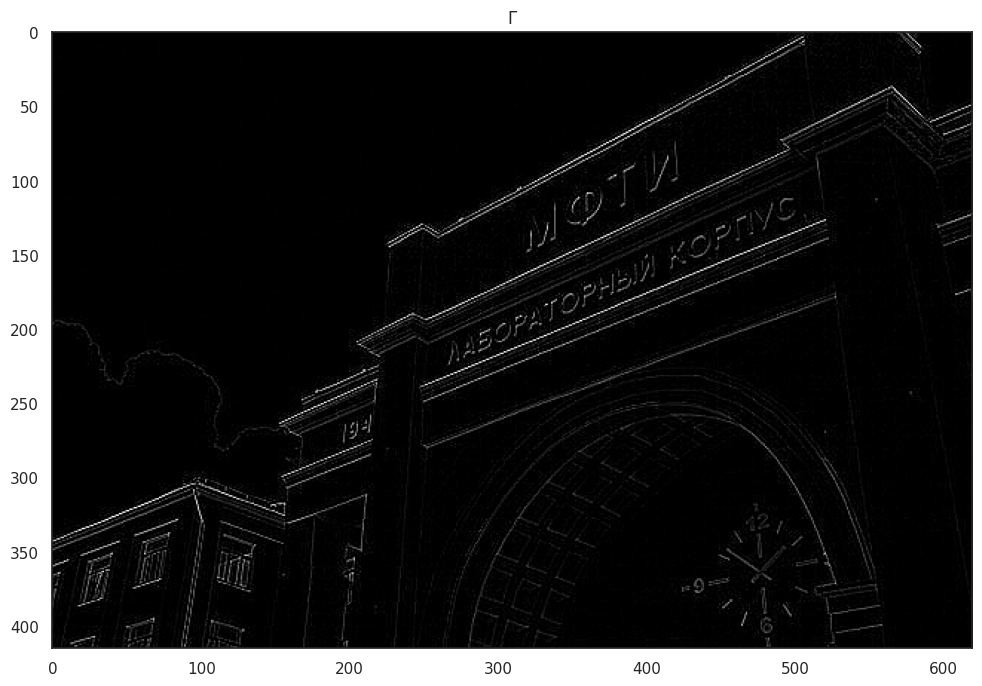

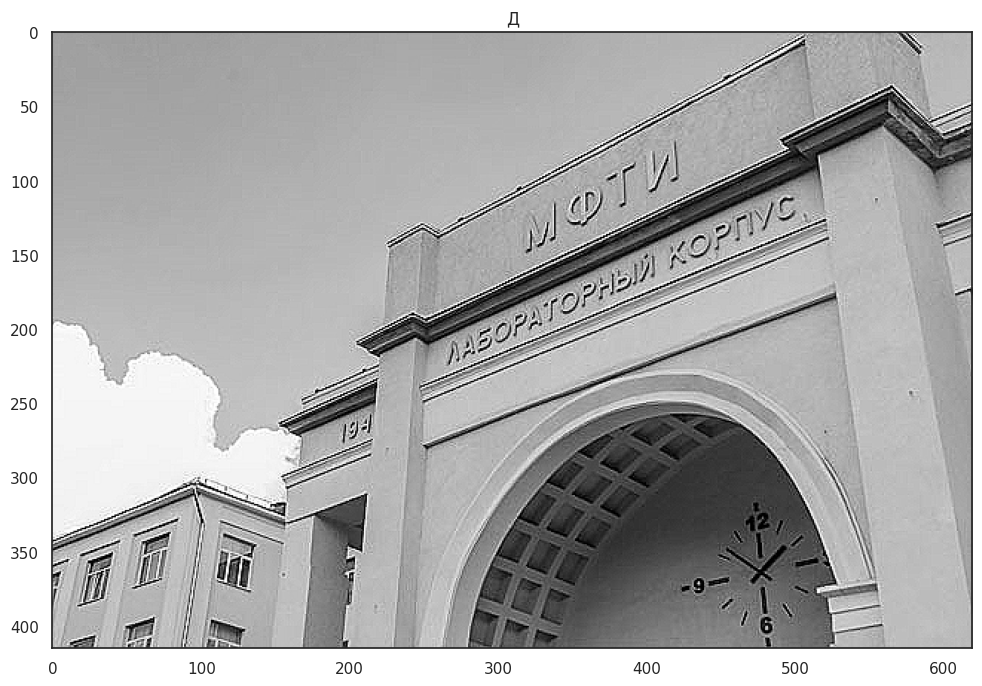

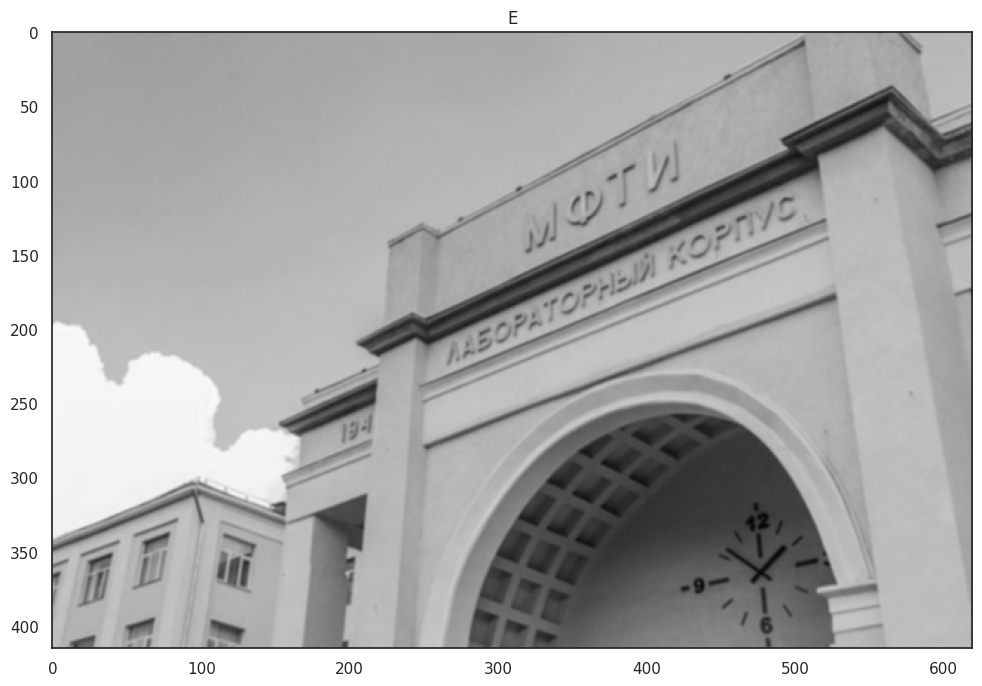

In [ ]:
for result, name in zip(results, masks_names):
  plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3

  plt.imshow(result_np)
  plt.title(name)
  plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

А 3

Б 5

В 4

Г 6

Д 2

Е 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # 6 input channels, 16 output channels, 3x3 square conv kernel with ReLU activation
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = self.flatten(x)

        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
# Set the model to evaluation mode
accuracy = train_evaluate(model)

Epoch: 1
Loader: train. Accuracy: 0.8858166666666667
Loader: valid. Accuracy: 0.9703
Epoch: 2
Loader: train. Accuracy: 0.9721833333333333
Loader: valid. Accuracy: 0.9762
Epoch: 3
Loader: train. Accuracy: 0.9801833333333333
Loader: valid. Accuracy: 0.9789
Epoch: 4
Loader: train. Accuracy: 0.98445
Loader: valid. Accuracy: 0.9855
Epoch: 5
Loader: train. Accuracy: 0.9872
Loader: valid. Accuracy: 0.9843
Epoch: 6
Loader: train. Accuracy: 0.9882666666666666
Loader: valid. Accuracy: 0.9869
Epoch: 7
Loader: train. Accuracy: 0.9902333333333333
Loader: valid. Accuracy: 0.9882
Epoch: 8
Loader: train. Accuracy: 0.9913833333333333
Loader: valid. Accuracy: 0.9881
Epoch: 9
Loader: train. Accuracy: 0.9923
Loader: valid. Accuracy: 0.9859
Epoch: 10
Loader: train. Accuracy: 0.9929666666666667
Loader: valid. Accuracy: 0.9878


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

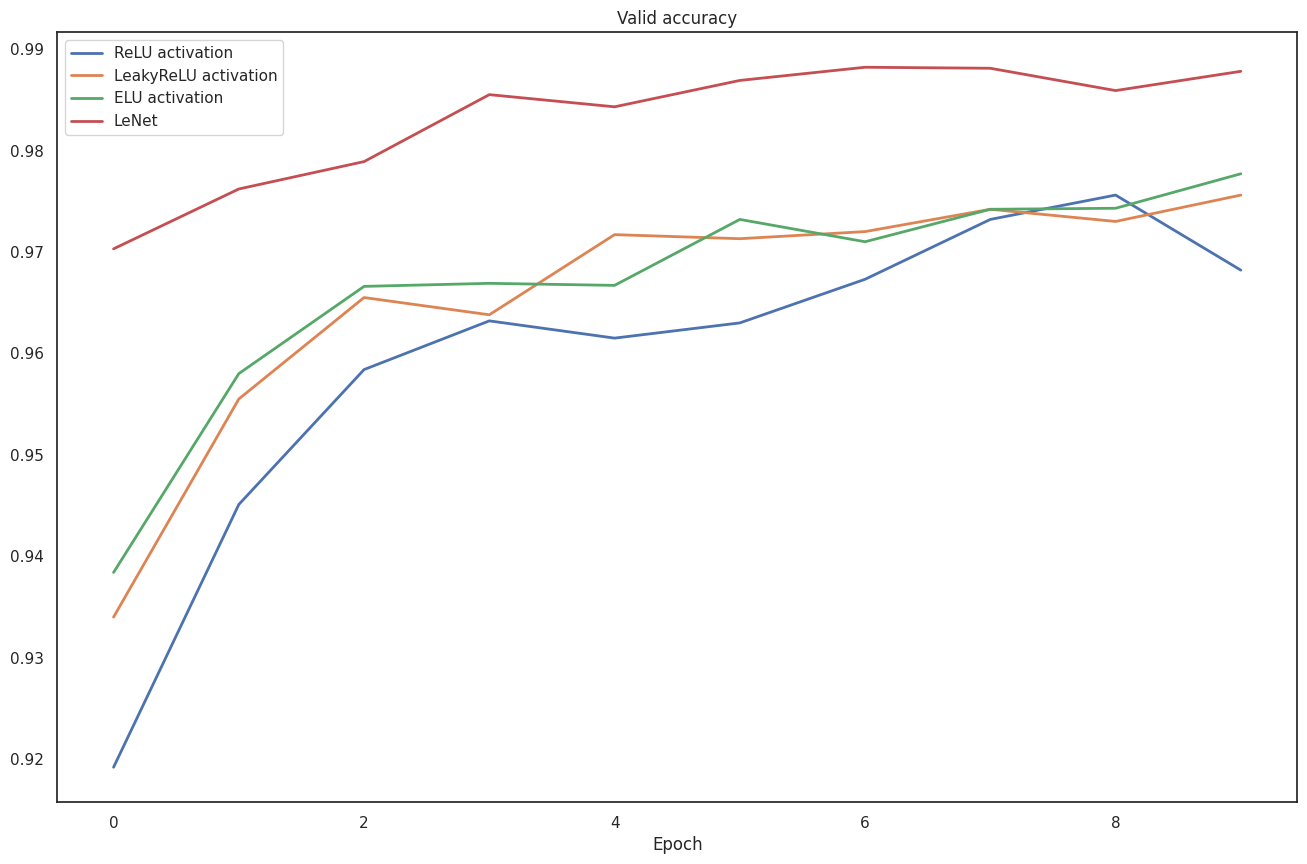

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(len(relu_accuracy)), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(len(leaky_relu_accuracy)), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(len(elu_accuracy)), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(len(lenet_accuracy)), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99